#### Objective : This code make use of complaint data against financial companies to perform following tasks on the data
    1. Identify company names using NER tagging
    2. Create Topic models to classify comlplaints in various categories

#### About the Dataset
The dataset comprises of Consumer Complaints on Financial products and we’ll see how to classify consumer complaints text into these categories: Debt collection, Consumer Loan, Mortgage, Credit card, Credit reporting, Student loan, Bank account or service, Payday loan, Money transfers, Other financial service, Prepaid card.
Also we will try to identify the companies from the dataset

#### Import the required package

In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import nltk
import spacy
import seaborn as sns
import pickle

### Read the complaints data csv

In [2]:
complaint_data = pd.read_csv("Consumer_Complaints.csv")

C:\Users\ash\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
### Convert the columns names so that they don't have space and are more readable
complaint_data.columns = [i.lower().replace(" ","_").replace("-","_") for i in complaint_data.columns]
complaint_data.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zip_code', 'tags', 'consumer_consent_provided?',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response?', 'consumer_disputed?', 'complaint_id'],
      dtype='object')

### Lets understand the shape an dtypes of the data

In [4]:
print ("The shape of data is ",complaint_data.shape)
print ("The data types for our data are as follows ")
print (complaint_data.info())

print (complaint_data.describe())

The shape of data is  (670598, 18)
The data types for our data are as follows 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670598 entries, 0 to 670597
Data columns (total 18 columns):
date_received                   670598 non-null object
product                         670598 non-null object
sub_product                     472396 non-null object
issue                           670598 non-null object
sub_issue                       269868 non-null object
consumer_complaint_narrative    114704 non-null object
company_public_response         145197 non-null object
company                         670598 non-null object
state                           665293 non-null object
zip_code                        665274 non-null object
tags                            94730 non-null object
consumer_consent_provided?      208151 non-null object
submitted_via                   670598 non-null object
date_sent_to_company            670598 non-null object
company_response_to_consumer    670598 no

In [5]:
### All the varables are text - which may correspond to categories and other variables
print (" The number of unique values in each column is as follows")
### Lets do a describe with including objects
complaint_data.describe(include = 'object').T.reset_index()


 The number of unique values in each column is as follows


,index,count,unique,top,freq
0,date_received,670598,1818,08/27/2015,963
1,product,670598,12,Mortgage,210324
2,sub_product,472396,47,Other mortgage,81715
3,issue,670598,95,"Loan modification,collection,foreclosure",106455
4,sub_issue,269868,68,Account status,32633
5,consumer_complaint_narrative,114704,112690,I am filing this complaint because Experian ha...,102
6,company_public_response,145197,10,Company has responded to the consumer and the ...,57364
7,company,670598,3933,Bank of America,61720
8,state,665293,62,CA,97640
9,zip_code,665274,27889,300XX,2147


######  From above description we see that only 114704 rows have complaint text and as we are interested in only those row which have complaint text. We wll drop all rows where complaint narrative is na

In [6]:
#### Keep only the consumer complaints is not null
complaint_data = complaint_data[~complaint_data['consumer_complaint_narrative'].isna()]

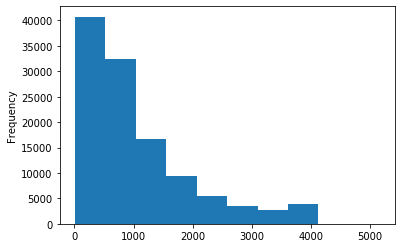

In [7]:
#### Create a distirbution of length of customers complaints. We have very left skew in length of complaints
### Which is expected as most compalints can be written in less than 500 words
complaint_data['consumer_complaint_narrative'].apply(len).plot(kind = 'hist')

In [8]:
### Keep the length columns as a new column
complaint_data['comp_length'] = complaint_data['consumer_complaint_narrative'].apply(len)

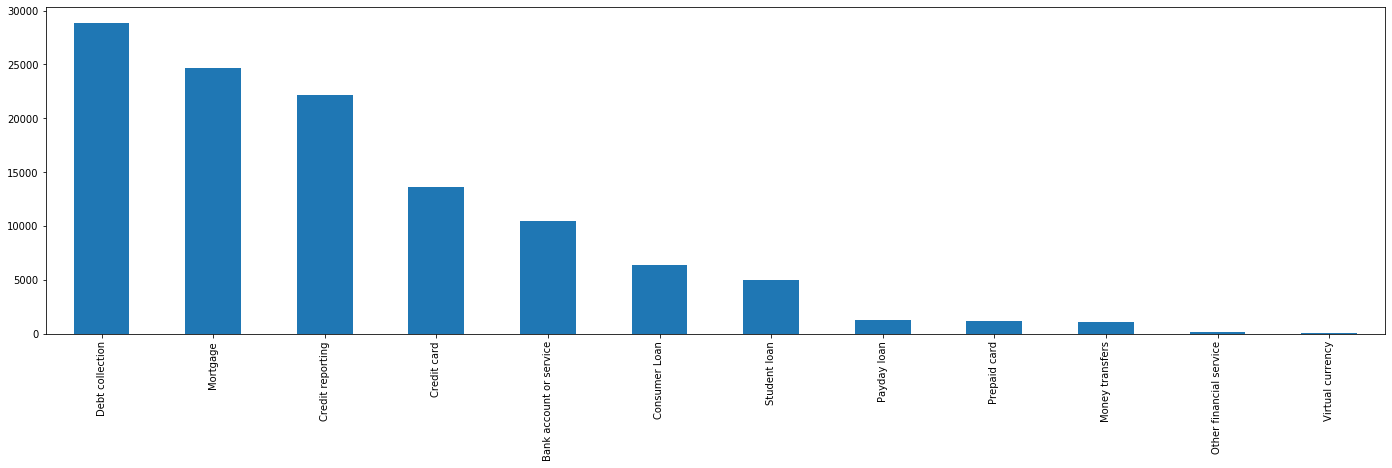

In [9]:
### Lets look at compalints distribution by product type
fig,ax = plt.subplots(figsize=(24,6))
complaint_data['product'].value_counts().plot(kind = 'bar')

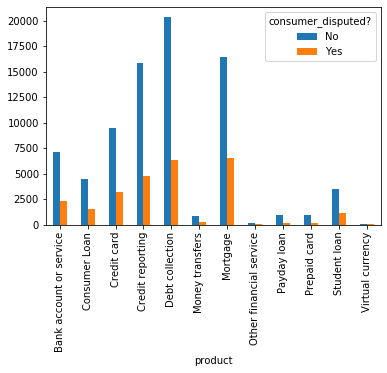

In [10]:
### Lets look at the distribution of every product by distputed or not
pd.crosstab(complaint_data['product'],complaint_data['consumer_disputed?']).plot(kind='bar')

In [11]:
### Lets look at the company data

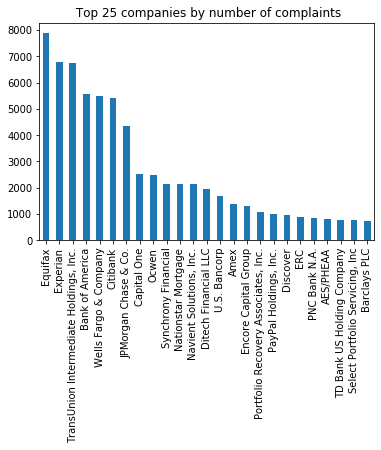

In [12]:
complaint_data['company'].value_counts()[0:25].plot(kind= 'bar',title = ' Top 25 companies by number of complaints')

### Objective 1 :  For learning purpose we will assume we don't have any company names and try to assign company name to each complaint with text using NLP

In [13]:
### Lets do some cleaning on the data. Mainly we will remove the stopwords and XXXX marks from our data
### In this data some word are masked due to sensitivity of the data

complaint_data['consumer_complaint_narrative'] =complaint_data['consumer_complaint_narrative'].str.replace(r'[^\w\s]',"")
complaint_data['consumer_complaint_narrative'] = complaint_data['consumer_complaint_narrative'].str.replace(r"XX+\s","")

### Define a function which applies NER tagging and return a list of ORG found in data

In [14]:
#### Defined extract entities names and store it in a list 
def extract_org_list(str1):
    ''' This will take a str1 and extract the list of organization. This will be stored as a list of organisations'''
    ### We are using the predefined ner parser tagging
    docs = nlp(str1)
    
    ### We will return a list 
    return ( [str(i) for i in docs.ents if i.label_ == 'ORG'])
    

In [15]:
### Test the function out on 10 columns and the apply it to whole datasets

In [16]:
cmp = complaint_data.iloc[0:10]
nlp = spacy.load('en_core_web_sm')

In [17]:
cmp1 =cmp['consumer_complaint_narrative'].apply(extract_org_list)

In [18]:
cmp1

57729    [Applied, USPMO, USPMO, Capital One, USPMO, Ca...
57787                                                   []
57838    [Charter One BankRBS Citizens Bank, Financial ...
57848                                                   []
57852                                                   []
57864                                              [noone]
57865    [Collection Consultants, Collection Consultant...
57868                                                   []
57871                                                   []
57872                                                   []
Name: consumer_complaint_narrative, dtype: object

### The function is working as it should , apply it to complete data

In [28]:
complaint_data['org_list_spacy'] = complaint_data['consumer_complaint_narrative'].apply(extract_org_list)
### Store the output in text file so that we don't have to run the model again
complaint_data.to_csv("text.csv")

In [29]:
# complaint_data = pd.read_csv("text.csv")

### After looking at the list of Organization we need to perform a few things of the data

    1. 40K claims model is not able to identify Orgs, on manual QA it seems the compalints dont have company name 
    2. As it is free text, each organisation can be written in multiple ways for example Capital One is written as following
        ["Cap One","Capital One Bank","Cap One Corp",'the Capital One Bank', 'Capital One' ] etc
    3. We need to create a method of normalizing the company names to the required list

In [37]:
org_dict = {}
org_dict_clean ={}

for i in complaint_data['org_list_spacy']:
  
    for org_name in i :
        org_dict_clean[org_name] = str(org_name).lower().strip()
        org_name = str(org_name).lower().strip()
        if org_name in org_dict:
            org_dict[org_name] += 1
        else:
            org_dict[org_name] = 1
            

In [39]:
import pickle
with open('org_dict1.pickle','wb') as filereq:
    pickle.dump(org_dict,filereq)

with open('org_dict2.pickle','wb') as filereq:
    pickle.dump(org_dict_clean,filereq)

In [40]:
### Load the pickled dictionary
with open('org_dict1.pickle','rb') as filereq:
    org_dict = pickle.load(filereq)


In [41]:
#### Sort the dictionary by values and remove any v is less than 10
org_sort = {k: v for k, v in sorted(org_dict.items(), key=lambda item: item[1],reverse=True) if v > 5}

In [42]:
### List names append 
org_names_list = []
for i in org_sort:
    org_names_list.append(i)
    

In [3]:
from fuzzywuzzy import fuzz

C:\Users\ash\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#### We have create dictionary of company names right now but we have following issues :

1. Company names are not normalised
2. Few Noise terms which do not repspond to company names but are recognised as Companies

Problem 1 - Suggested Solution :
    1. Create a matching score between every company names in the stored dictionary. We can use fuzzy wuzzy matching for the same
    2. Based on fuzzy wuzzy matching scoring algorithm metric, create cluster. As we are not sure of how many clsuters be used we will use a Affinity clustering algorithm
    3. Once the cluster is created, assign names based which has highest similarity score to everyone else in the cluster
    
Problem 2 - Suggested Solutions:
    1. Hypothesis : The freq of these noise terms would be very much less than the freqeuncy of comapny names
    2. We should do this on cluster frequency rather than the individual words as individual frequency can be biased and not reliable due to different names used
        